Author: Matthias Rueedlinger, (public AT rueedlinger.ch)

GitHub: https://github.com/rueedlinger/noestimates


# Forecasting with a Monte Carlo Simulation

This example shows you can use a monte carlo simulation with cycle time from previous work items to forecast how long the rest of the work items will take. This article is inspired from previous publication. For more details have look at the __reference section__ in the [README](https://github.com/rueedlinger/noestimates) of this github project.

## Get Started

First we need some python packages for our simulation.

- _matplotlib_ - for plotting  nice charts.
- _random_ - for our Monte Carlo simulation. By the way a Monte Carlo simulation is a fancy word from random sampling.
- _numpy_ - load data and calulcate the median, standard deviation and percentiles.

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import random
import numpy as np

## When will it be done?

"When will it be done?"  So we want to know when are the next work items are done.

In [2]:
total_work_items = 30

In [3]:
cycle_times = [2, 3, 5, 8, 3, 5 , 6, 2, 8, 1, 4, 3, 1]

In [4]:
def cumulative_sum(total_work_items, cycle_times, selector):
    total = [0]
    for i, e in enumerate(range(total_work_items)):
            total.append(selector(cycle_times) + total[i])
    return total    

In [5]:
cumulative_sum_min = cumulative_sum(total_work_items, cycle_times, min)
cumulative_sum_max = cumulative_sum(total_work_items, cycle_times, max)
cumulative_random = cumulative_sum(total_work_items, cycle_times, random.choice)

In [6]:
range_work_items = [x for x in range(total_work_items + 1)]

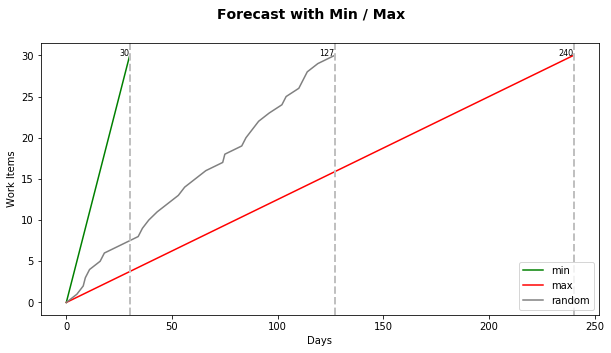

In [7]:

fig, ax = plt.subplots(figsize=(10, 5))


fig.suptitle('Forecast with Min / Max', fontsize=14, fontweight='bold')

plt.plot(cumulative_sum_min, range_work_items, label='min',  color='green')
plt.plot(cumulative_sum_max, range_work_items, label='max', color='red')
plt.plot(cumulative_random, range_work_items, label='random', color='gray')

value_max = cumulative_sum_max[-1]
value_min = cumulative_sum_min[-1]
value_random =  cumulative_random[-1]

plt.axvline(value_max, color='silver', linestyle='dashed', linewidth=2)
plt.axvline(value_min, color='silver', linestyle='dashed', linewidth=2)
plt.axvline(value_random, color='silver', linestyle='dashed', linewidth=2)

t = ax.text(value_max, total_work_items, value_max, ha="right", size=8)
t = ax.text(value_min, total_work_items, value_min, ha="right", size=8)
t = ax.text(value_random, total_work_items, value_random, ha="right", size=8)

ax.set_xlabel("Days")
ax.set_ylabel("Work Items")

plt.legend(loc='lower right')


plt.show()

#ax.xaxis.tick_top()

In [8]:
num_of_iterations = 1000

def simulate(num_of_iterations, total_work_items, cycle_times):
    list_random_walks = []
    totals = []
    
    for i in range(num_of_iterations):
        list_random_walks.append(
            cumulative_sum(total_work_items, cycle_times, random.choice))
    
    for i in list_random_walks:
        totals.append(i[-1])
    
    return totals, list_random_walks

simulated_total, simulated_work_done = simulate(num_of_iterations, total_work_items, cycle_times)

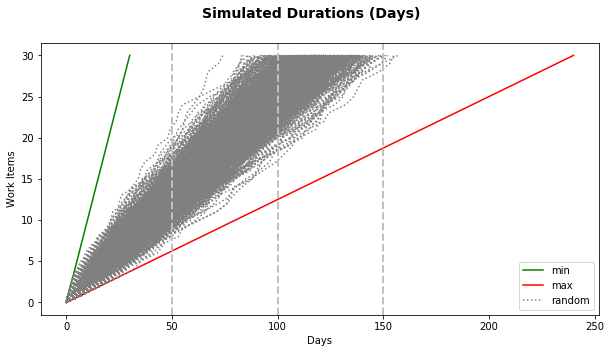

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

fig.suptitle('Simulated Durations (Days)', fontsize=14, fontweight='bold')

plt.plot(cumulative_sum_min, range_work_items, label='min',  color='green')
plt.plot(cumulative_sum_max, range_work_items, label='max', color='red')
plt.plot(0, 0, linestyle='dotted', color='gray', label='random')


for r in simulated_work_done:
    plt.plot(r, range_work_items, linestyle='dotted', color='gray')

plt.axvline(50, color='silver', linestyle='dashed', linewidth=2)
plt.axvline(100, color='silver', linestyle='dashed', linewidth=2)
plt.axvline(150, color='silver', linestyle='dashed', linewidth=2)

ax.set_xlabel("Days")
ax.set_ylabel("Work Items")

plt.legend(loc='lower right')
plt.show()


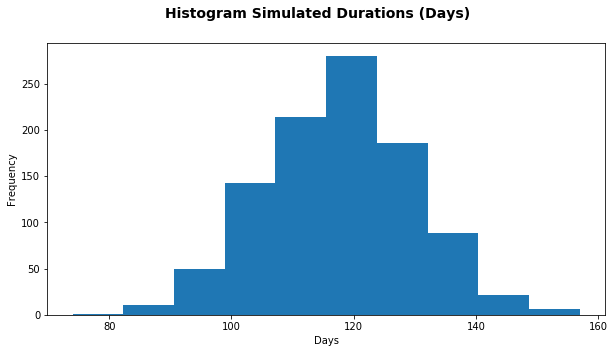

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Histogram Simulated Durations (Days)', fontsize=14, fontweight='bold')
ax.set_xlabel('Days')
ax.set_ylabel('Frequency')
plt.hist(simulated_total);

In [14]:
q = [50, 85, 90, 95, 99]
p = np.percentile(simulated_total, q)
p

array([ 117.  ,  130.  ,  134.  ,  138.  ,  145.01])

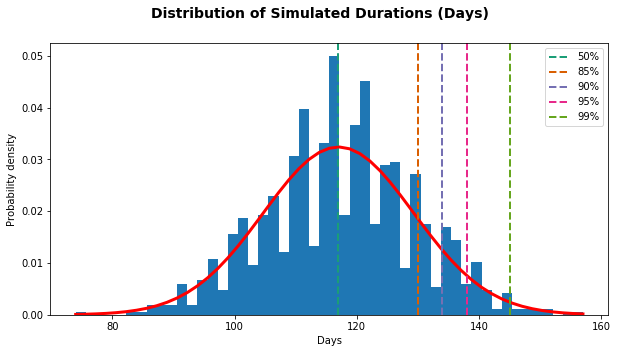

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))

fig.suptitle('Distribution of Simulated Durations (Days)', fontsize=14, fontweight='bold')

num_bins = 50

mu = np.median(simulated_total)
sigma = np.std(simulated_total)

# the histogram of the data
n, bins, patches = ax.hist(simulated_total, num_bins, normed=1)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
ax.plot(bins, y, color='red', linestyle='solid', linewidth=3)
ax.set_xlabel('Days')
ax.set_ylabel('Probability density')

cm = plt.cm.get_cmap('Dark2')


for i, v in enumerate(p):
    plt.axvline(v, color=cm.colors[i], linestyle='dashed', linewidth=2, label=str(q[i]) + '%')

plt.legend(loc='upper right')
plt.show()